# Creating and Re-Training Models

Roboflow provides you with tools to create your computer vision (CV) models.

Creating robust CV models is centered around gathering a representative dataset and iterating on that dataset as your model needs to improve.

Let's walk through an example of retraining a computer vision model on Roboflow to fix a prediction error.

In [1]:
import roboflow
roboflow.login()

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).


loading Roboflow workspace...
loading Roboflow project...


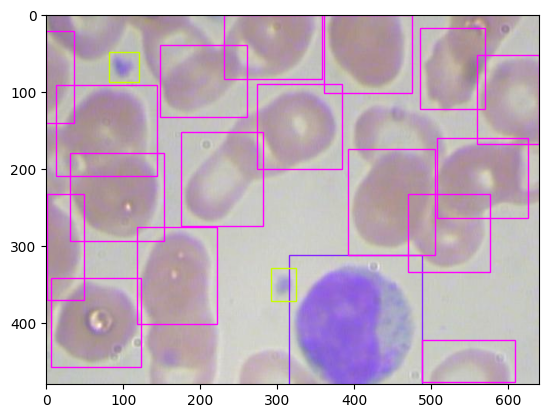

In [2]:
#this model has been trained to identify red blood cells, white blood cells, and platelets
#however, all of the dataset images come from the same microscope view below

img_url = "https://media.roboflow.com/quickstart/blood_cells1.jpeg?updatedAt=1678743538023"
universe_url = "https://universe.roboflow.com/joshua-kenan-cinches/bccd-yolov5-ntmab/model/1"

model = roboflow.load_model(model_url=universe_url)
pred = model.predict(img_url, hosted=True, confidence=10)
pred.plot()

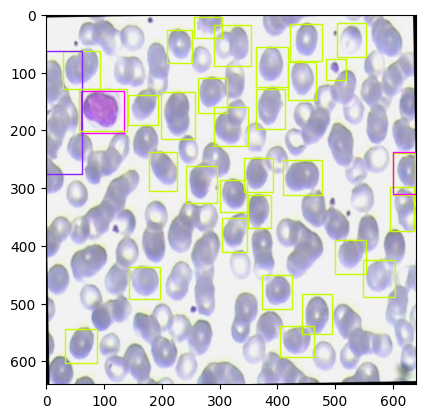

In [3]:
#we can see that this model performs poorly on blood cell images taken from a different microscope
img_url = "https://media.roboflow.com/quickstart/blood_cells2.jpeg?updatedAt=1678743546000"
pred = model.predict(img_url, hosted=True, confidence=50)
pred.plot()


## Active Learning: Fixing Model Predictions by Re-Training our Model

To retrain the model we will:

* Create a new project in Roboflow
* Download and upload the original model's dataset to the project
* Upload labeled data from the new microsope angle to the new proejct
* Generate a new dataset version and retrain it

In [4]:
#create new roboflow project
from roboflow import Roboflow
workspace = Roboflow().workspace()
new_project = workspace.create_project(project_name="blood-cells-retraining6",project_license="MIT",project_type="object-detection", annotation="cells1023")


loading Roboflow workspace...
loading Roboflow project...


In [5]:
#download old dataset images
rf = Roboflow()
old_microscope_project = rf.workspace("joshua-kenan-cinches").project("bccd-yolov5-ntmab")
old_microscope_dataset = old_microscope_project.version(2).download("voc")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to bccd-yolov5-2 in voc:: 100%|█| 733/733 [00:00<


In [12]:
#add new images
#here we will add pre labeled images - in most cases you will need to annotate new images to 
new_microscope_project = rf.workspace("roboflow-gw7yv").project("blood-cell-new-microscope")
new_microscope_dataset = new_microscope_project.version(2).download("voc")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Blood-Cell-New-Microscope-2 in voc:: 100%|█| 1


In [8]:
import glob
import random
from tqdm import tqdm

#upload old microscope training images
pbar = tqdm(glob.glob(old_microscope_dataset.location + "/train/*.jpg"))
for img_file in pbar:
    label_file = img_file.replace(".jpg", ".xml")
    new_project.upload(image_path=img_file, annotation_path=label_file, split="train")

#upload old microscope validation images
for img_file in tqdm(glob.glob(old_microscope_dataset.location + "/valid/*.jpg")):
    label_file = img_file.replace(".jpg", ".xml")
    new_project.upload(image_path=img_file, annotation_path=label_file, split="valid")
    
#upload old microscope test images
for img_file in tqdm(glob.glob(old_microscope_dataset.location + "/test/*.jpg")):
    label_file = img_file.replace(".jpg", ".xml")
    new_project.upload(image_path=img_file, annotation_path=label_file, split="test")

#upload new microscope to new splits with probability 70,20,10
for img_file in tqdm(glob.glob(new_microscope_dataset.location + "/train/*.jpg")):
    label_file = img_file.replace(".jpg", ".xml")
    split = random.choice(["train"]*7 + ["valid"]*2 + ["test"]*1)
    new_project.upload(image_path=img_file, annotation_path=label_file, split="train")

100%|█████████████████████████████████████████| 255/255 [05:44<00:00,  1.35s/it]


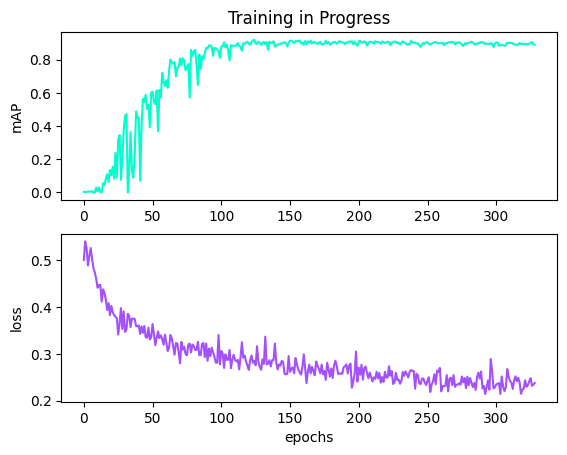

In [9]:
from roboflow import Roboflow
# workspace = Roboflow().workspace()
# new_project = workspace.project("blood-cells-retraining3")
new_model = new_project.train(plot_in_notebook=True)

In [10]:
#uncomment to load pre baked model if you don't want to wait for training to complete

# import roboflow
# from urllib.parse import urlparse
# universe_model_url = "https://universe.roboflow.com/jacob-solawetz/blood-cells-combined-xujui/model/1"
# new_model = roboflow.load_model(model_url=universe_model_url)

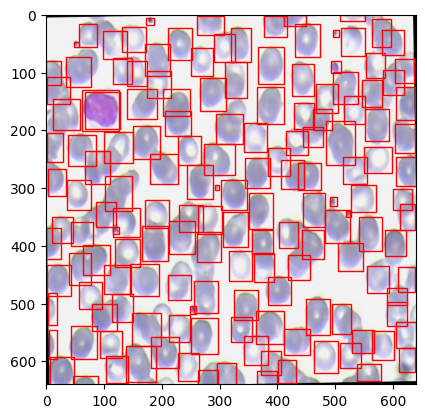

In [15]:
img_url = "https://media.roboflow.com/quickstart/blood_cells2.jpeg?updatedAt=1678743546000"
pred = new_model.predict(img_url, hosted=True, confidence=60)
pred.plot()

In [13]:
pred.json()

{'predictions': [{'x': 140.5,
   'y': 412.5,
   'width': 43.0,
   'height': 49.0,
   'confidence': 0.9125190377235413,
   'class': 'RBC',
   'image_path': 'https://storage.googleapis.com/roboflow-platform-sources/Un6Oj918VoacT7AE2ql63T5q4ft1/85ljLudEpEbiURKj8MQO/original.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 388.5,
   'y': 87.5,
   'width': 45.0,
   'height': 63.0,
   'confidence': 0.9033741354942322,
   'class': 'RBC',
   'image_path': 'https://storage.googleapis.com/roboflow-platform-sources/Un6Oj918VoacT7AE2ql63T5q4ft1/85ljLudEpEbiURKj8MQO/original.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 402.0,
   'y': 254.5,
   'width': 38.0,
   'height': 49.0,
   'confidence': 0.9025548696517944,
   'class': 'RBC',
   'image_path': 'https://storage.googleapis.com/roboflow-platform-sources/Un6Oj918VoacT7AE2ql63T5q4ft1/85ljLudEpEbiURKj8MQO/original.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 387.0,
   'y': 540.5,
   'width': 48.0,
   'heig

In [14]:
#Through training and retraining procedures - you can quickly iterate on your CV datasets and models with Roboflow.

## Next Up: Roboflow Model Types

Next up, we will look into the differnt types of computer vision tasks you can accomplish with Roboflow. 

* object detection
* classification
* instance segmentation
* semantic segmentation

In [17]:
from notebook import notebookapp
import webbrowser
jupyter_server = list(notebookapp.list_running_servers())[0]["url"]
webbrowser.open(jupyter_server + "notebooks/model-types.ipynb")

True